In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(42)

In [21]:
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import clone_model

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from conv_utils import *

# Data Preprocessing

In [22]:
# symbol_list = ['apple', 'banana', 'cherry', 'grape', 'kiwi', 'orange', 'kiwi']
# data_dict = {}
# for symbol in symbol_list:
#     data_dict[symbol] = load_raw_data(symbol)

# all intraday data has 1440 rows(minutes) 
#
# symbol,fruit,open,close
# es,apple,08:30:00 AM,03:15:00 PM
# ty,orange,07:20:00 AM,02:00:00 PM
# gl,grape,08:00:00 AM,04:30:00 PM
# ft,cherry,08:00:00 AM,04:30:00 PM
# xx,peach,09:00:00 AM,05:30:00 PM
# bl,pear,09:00:00 AM,05:30:00 PM
# cl,banana,09:00:00 AM,02:30:00 PM
# gc,kiwi,08:20:00 AM,01:30:00 PM   --> rows 510:810
# 

In [23]:
RawData = load_raw_data(symbol='kiwi', trading_start=510, trading_end=810)

5371it [00:14, 360.05it/s]


In [24]:
X_train, X_test, X_valid = RawData

In [25]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(3753, 300, 1)
(896, 300, 1)
(356, 300, 1)


# Autoencoder Model

$$new\ width(height) = \frac{width(height) - F + 2 \times P}{S} + 1$$

In [26]:
timesteps = 300 #1440
input_dim = 1

n_epochs = 300
batch_size = 32

In [27]:
encoder = Sequential([
    Input(shape=(timesteps, input_dim)),
    
    Conv1D(filters=6, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(5, padding='valid'),

    Conv1D(filters=6, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(3, padding='valid'),

    Conv1D(filters=8, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2, padding='valid'),

    Conv1D(filters=8, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2, padding='valid'),
])

In [29]:
Conv1DAuto = Sequential([
    encoder,
    
    Conv1D(filters=8, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    UpSampling1D(2),

    Conv1D(filters=8, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    UpSampling1D(2),

    Conv1D(filters=6, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    UpSampling1D(3),

    Conv1D(filters=6, kernel_size=2, strides=1, padding='causal', activation='relu'),
    BatchNormalization(),
    UpSampling1D(5),
    Conv1D(filters=1, kernel_size=2, strides=1, padding='causal', activation='sigmoid'),
])

In [30]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                  epsilon=None, decay=0.0, amsgrad=False)

checkpoint_cb = ModelCheckpoint('Conv1DAuto_V4_daySession.h5', save_best_only=True)

earlystopping_cb = EarlyStopping(patience=5)

In [31]:
Conv1DAuto.compile(loss='mse', optimizer=optimizer,
                     metrics=['mse'])

In [32]:
history = Conv1DAuto.fit(X_train, X_train, batch_size=batch_size, epochs=n_epochs,
                        callbacks=[checkpoint_cb, earlystopping_cb], 
                        validation_data=(X_valid, X_valid), 
                        verbose=False)

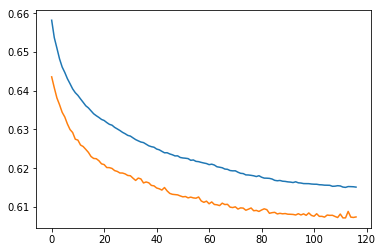

In [33]:
_ = plt.plot(history.history['loss'][6:])
_ = plt.plot(history.history['val_loss'][6:])

In [28]:
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 300, 6)            18        
_________________________________________________________________
batch_normalization_v2_8 (Ba (None, 300, 6)            24        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 60, 6)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 60, 6)             78        
_________________________________________________________________
batch_normalization_v2_9 (Ba (None, 60, 6)             24        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 20, 6)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 20, 8)            

In [34]:
Conv1DAuto.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 5, 8)              448       
_________________________________________________________________
conv1d_13 (Conv1D)           multiple                  136       
_________________________________________________________________
batch_normalization_v2_12 (B multiple                  32        
_________________________________________________________________
up_sampling1d_4 (UpSampling1 multiple                  0         
_________________________________________________________________
conv1d_14 (Conv1D)           multiple                  136       
_________________________________________________________________
batch_normalization_v2_13 (B multiple                  32        
_________________________________________________________________
up_sampling1d_5 (UpSampling1 multiple                 

# How the reconstruction looks?

In [35]:
X_pred = Conv1DAuto.predict(X_test)

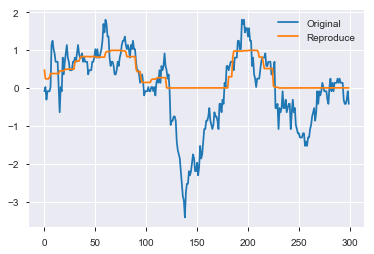

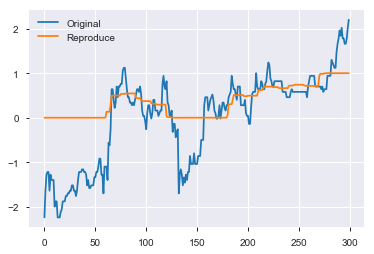

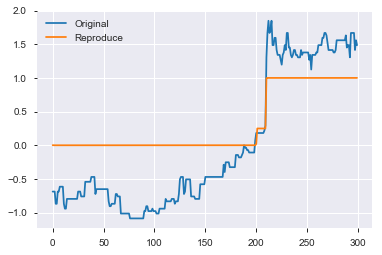

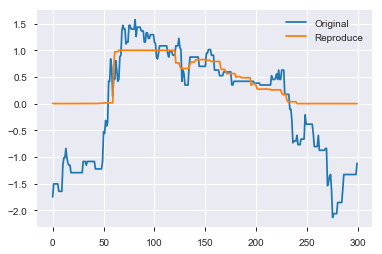

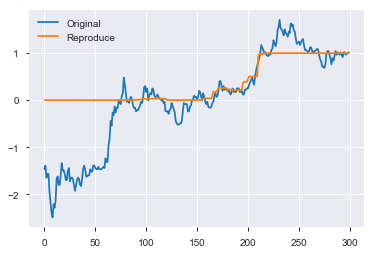

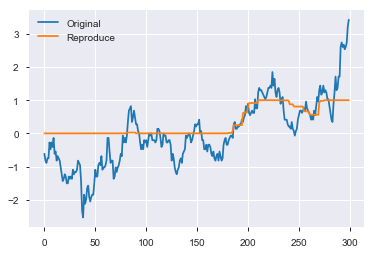

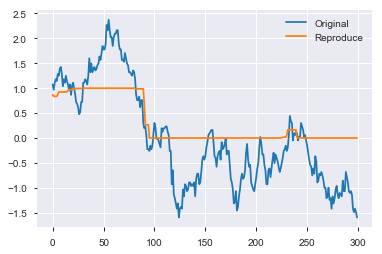

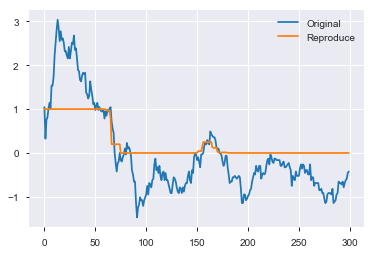

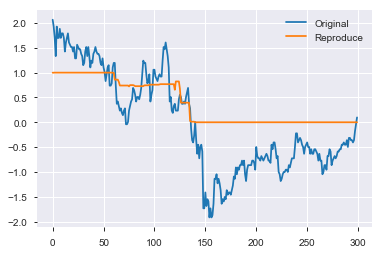

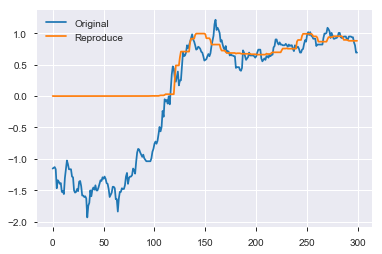

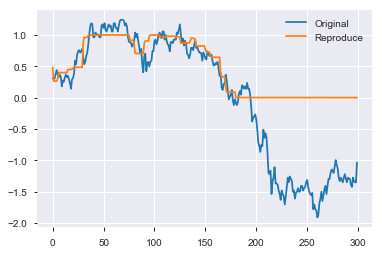

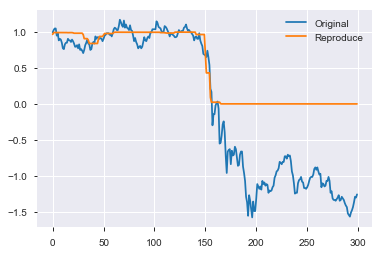

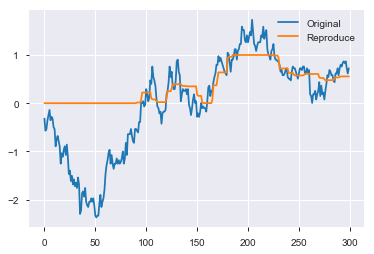

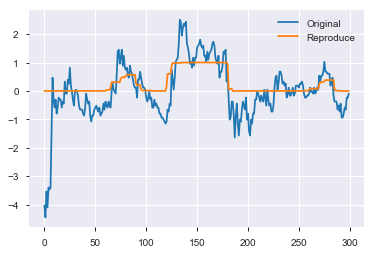

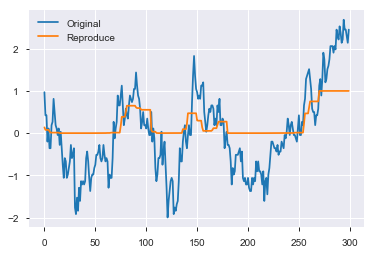

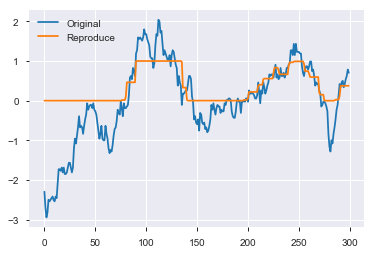

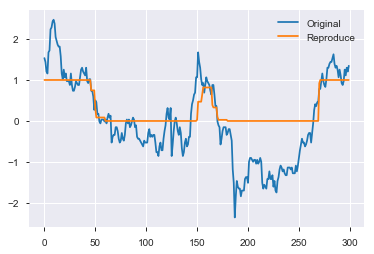

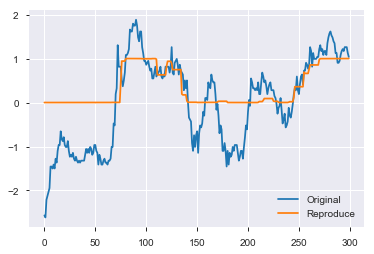

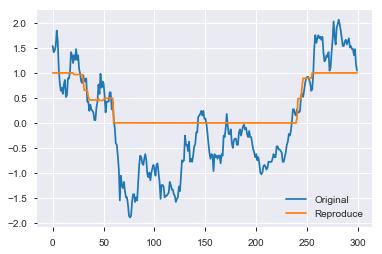

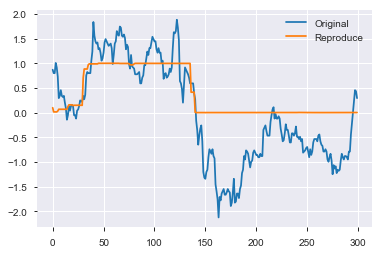

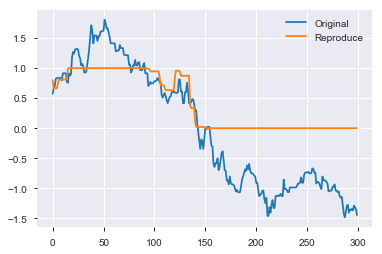

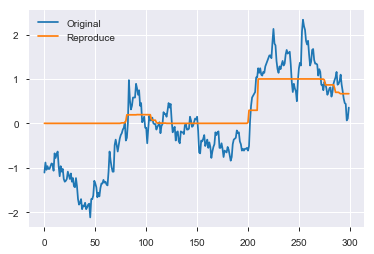

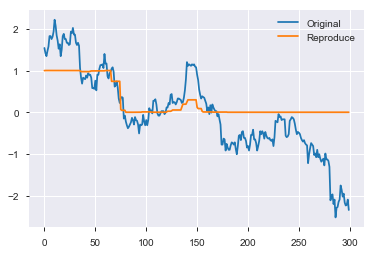

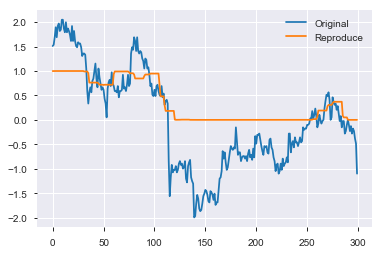

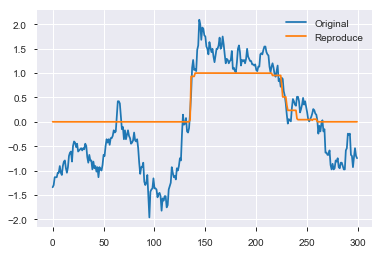

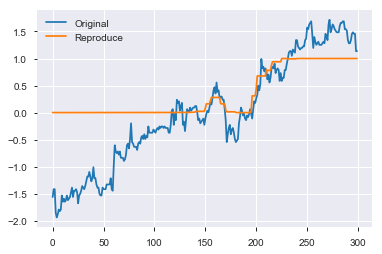

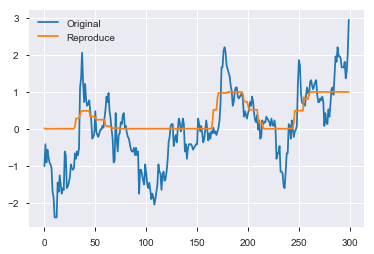

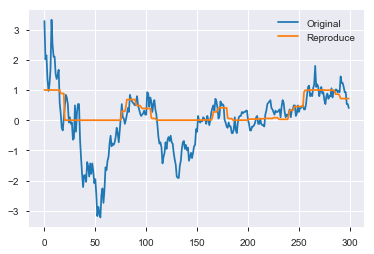

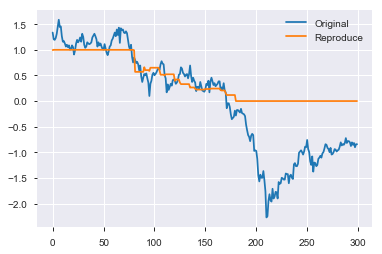

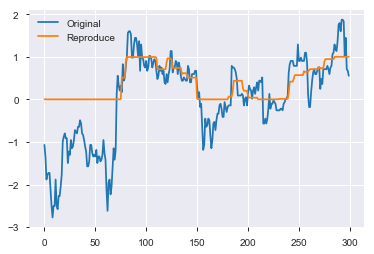

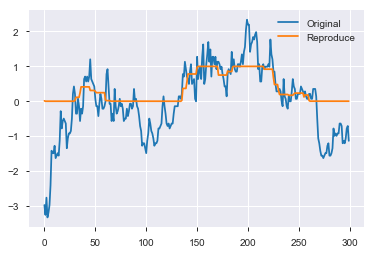

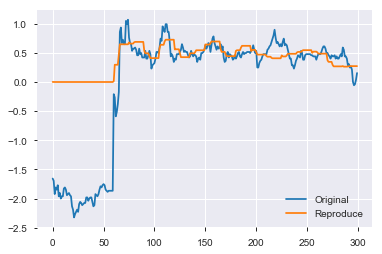

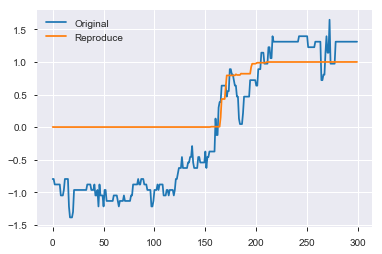

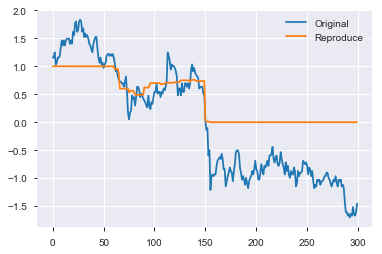

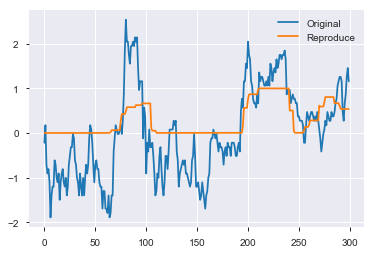

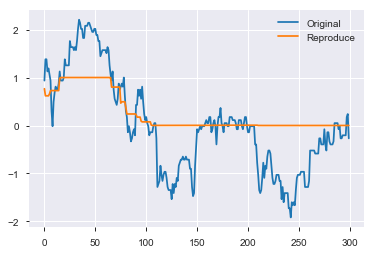

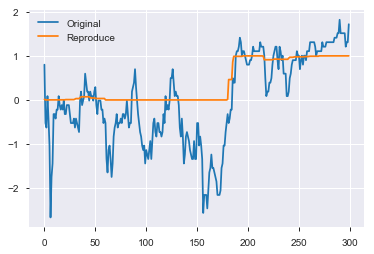

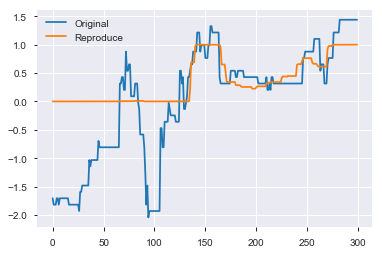

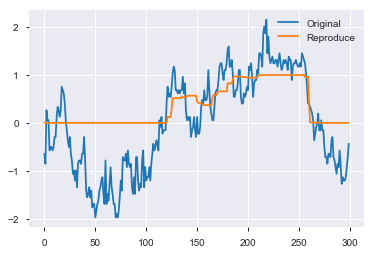

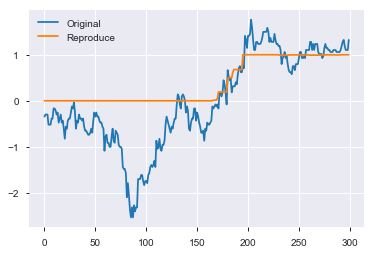

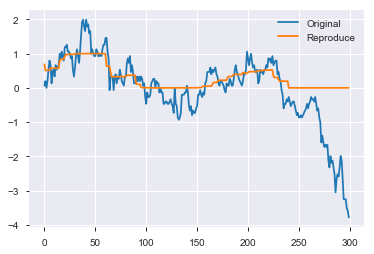

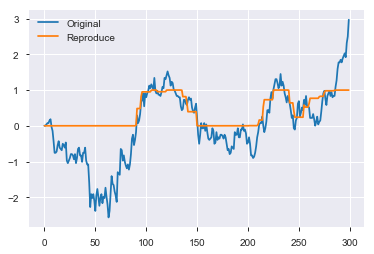

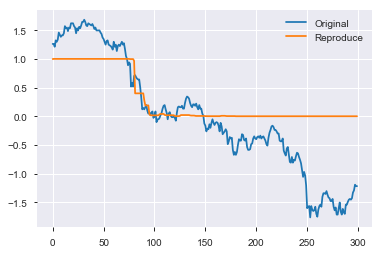

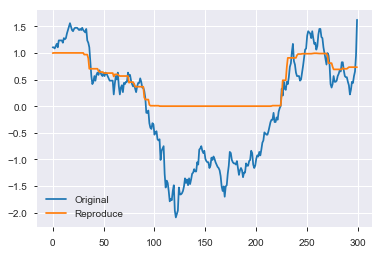

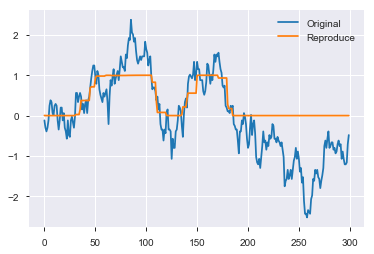

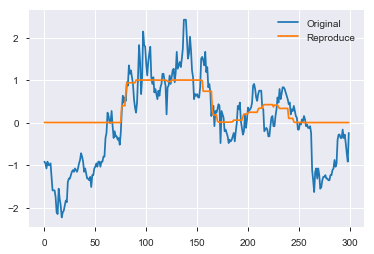

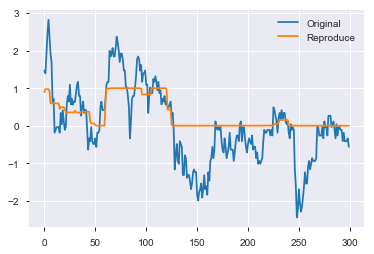

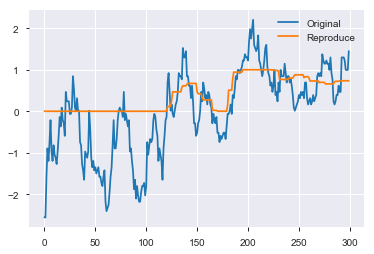

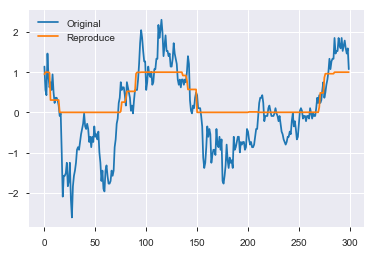

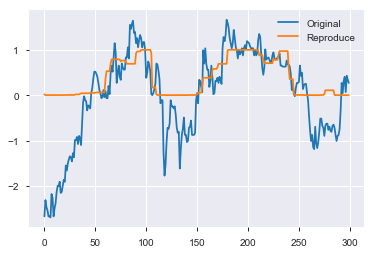

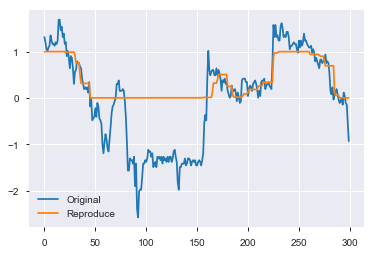

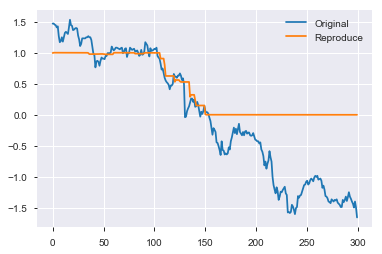

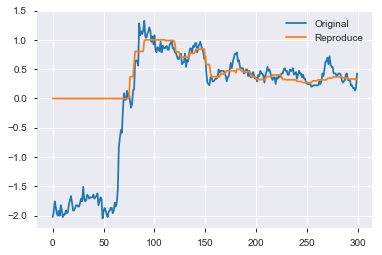

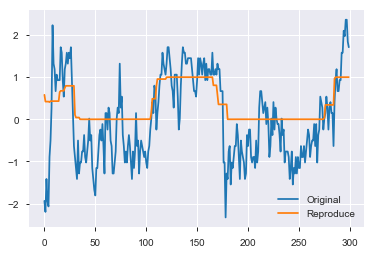

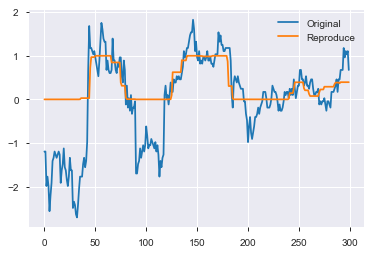

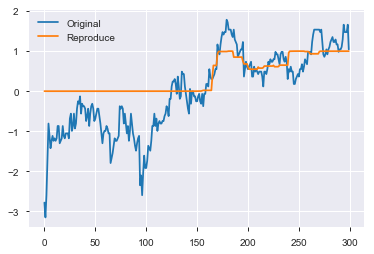

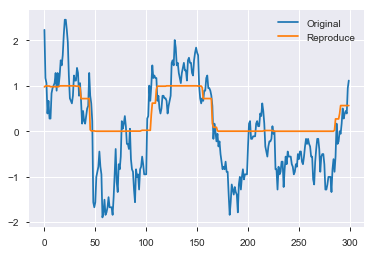

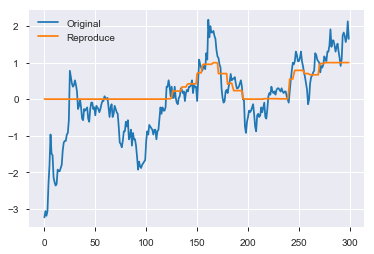

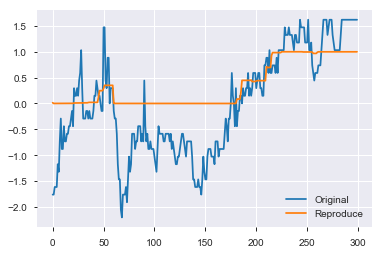

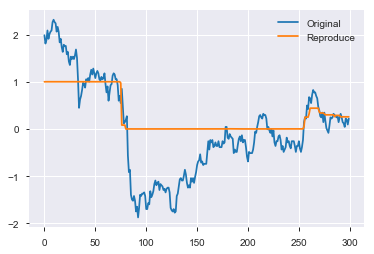

In [92]:
for i in range(len(X_pred)):
    if i % 15 == 0:
        plt.figure(figsize=(6,4))
        plt.plot(X_test[i], label='Original')
        plt.plot(X_pred[i], label='Reproduce')
        plt.legend()

# How the Encoded looks?

In [37]:
X_test_encoded = encoder.predict(X_test)

In [61]:
X_encoded = X_test_encoded.reshape(len(X_test_encoded), -1)

In [62]:
X_encoded.shape

(896, 40)

In [84]:
df = pd.DataFrame(X_encoded, columns=[str(i) for i in range(40)])

In [86]:
profile = df.profile_report()

In [87]:
profile